# Description

An image classifier (resizes to 168) for food. It is based on the imagenet weights and uses the food101 dataset from tensorflow. It is for the specific use case of tensorflow js

# Author

Jonathan Coletti (jonathancoletti0@gmail.com)

License apache 2.0

In [1]:
!pip install tensorflow==2.15 tensorflow-datasets tensorflowjs matplotlib tensorflowjs[wizard]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 90.9 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.5 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 KB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 79.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 17.2 MB/s

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import os

2025-10-05 19:56:50.261141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-05 19:56:50.261176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-05 19:56:50.261729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-05 19:56:50.265727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DATASET

The dataset is food 101 (https://www.tensorflow.org/datasets/catalog/food101)

- 101,000 images
- Approx 4gb
- 250 test images
- 101 food categories


This model performs **image classification** using a pretrained convolutional neural network backbone.

It identifies the **food category** of an image among 101 possible classes.

## Encoder (Feature Extractor)
Based on a convolutional backbone pretrained on **ImageNet (MobileNetV2)** (EfficientNetB0 does not work as it has a normilization layer)

1. Extracts hierarchical visual features from the input image.
2. Each convolutional block learns increasingly abstract representations.
3. The base model is initially frozen to retain pretrained weights.

## Classification Head
Adds lightweight dense layers on top of the encoder:

1. Global Average Pooling reduces spatial dimensions to a single feature vector.
2. A Dropout layer helps prevent overfitting.
3. A Dense layer with **101 output units in softmax form** provides the final class probabilities.


In [3]:
IMG_SIZE = 168
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 3
DROPOUT_RATE = 0.3
MAX_8_BIT_RGB_IMAGE = 255.0

In [4]:
print("GPU OR NO?", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU OR NO? True


2025-10-05 19:57:02.273000: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 19:57:02.278171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 19:57:02.278332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / MAX_8_BIT_RGB_IMAGE
    return image, label

train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Shuffling /root/tensorflow_datasets/food101/incomplete.DS1S6H_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.DS1S6H_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


2025-10-05 20:06:11.326359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 20:06:11.326530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-05 20:06:11.326637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=101
)

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = tf.keras.layers.Dense(ds_info.features["label"].num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 168, 168, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 84, 84, 32)           864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 84, 84, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

In [19]:
history = model.fit(train, epochs=EPOCHS, validation_data=test)

Epoch 1/3
2368/2368 [==============================] - 102s 37ms/step - loss: 2.3247 - accuracy: 0.4361 - val_loss: 1.4798 - val_accuracy: 0.6060
Epoch 2/3
2368/2368 [==============================] - 88s 37ms/step - loss: 1.3097 - accuracy: 0.6559 - val_loss: 1.3082 - val_accuracy: 0.6526
Epoch 3/3
2368/2368 [==============================] - 88s 37ms/step - loss: 0.8798 - accuracy: 0.7644 - val_loss: 1.2540 - val_accuracy: 0.6707


# Plots

Plot loss and accuracy

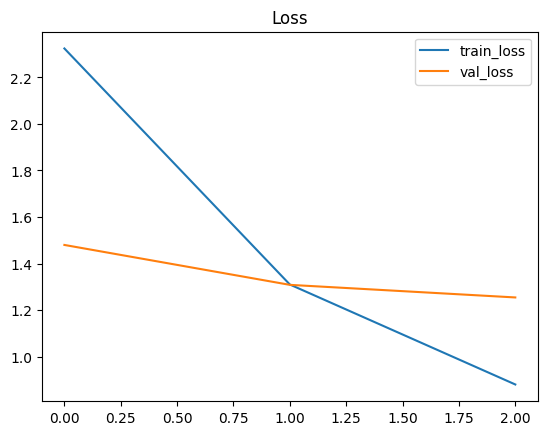

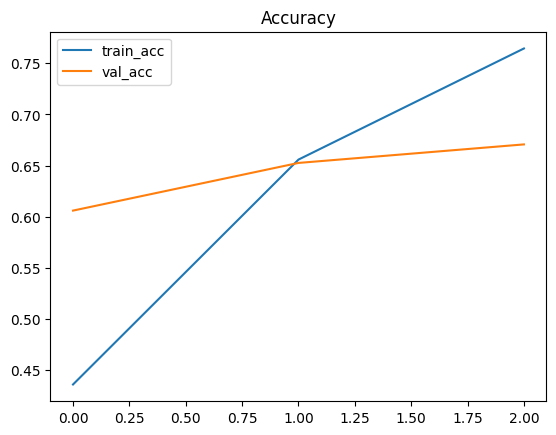

In [20]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")

plt.show()

In [29]:
!mkdir -p tfjs_food_classifier
model.save(f'tfjs_food_classifier/my_model.h5', save_format='h5')

In [30]:
!mkdir web_model
!tensorflowjs_converter --input_format keras tfjs_food_classifier/my_model.h5 ./web_model

mkdir: cannot create directory ‘web_model’: File exists
2025-10-05 22:22:13.832353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-05 22:22:13.832387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-05 22:22:13.832921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
